# [Lighthouse] Desafio Ciência de Dados

- Base: `desafio_indicium_imdb.csv`




### BIBLIOTECAS:

<span style="color:red">**OBS: RODE ESTA CELULA ANTES DE EXECUTAR AS OUTRAS ⬇️⬇️⬇️**</span>

In [19]:
# Importações para Manipulação e Análise de Dados
import numpy as np
import pandas as pd

# Importações para Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Importações para Scikit-learn (Pré-processamento e Modelagem)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Importações para Persistência de Modelo
import joblib




## Importando base de dados

In [20]:
df = pd.read_csv("desafio_indicium_imdb.csv")
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## EDA — visão geral e pré-processamento

- Checagem inicial de tipos, nulos e formato.
- Conversão de colunas numéricas (Runtime, Gross, Released_Year, No_of_Votes, IMDB_Rating, Meta_score).
- Padronização de strings e remoção de espaços extras.
- Tratamento de ausentes com moda/mediana conforme variável.
- Resumo final com shape, nulos restantes e dtypes.


### Identificando erros de tipagem

A ideia é anaálisar a tipagem de a cordo com o sentido da feature!

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


#### Verificando valores nulos nas features!

In [22]:
nulls = df.isna().sum()
nulls

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [23]:
# Carregar e copiar removendo coluna indesejada
df = df_raw.drop(columns=['Unnamed: 0'], errors='ignore')

# --- Limpeza de texto ---
obj_cols = df.select_dtypes('object').columns
df[obj_cols] = df[obj_cols].apply(lambda s: s.astype(str).str.strip())

# --- Conversões numéricas ---
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)
df['Gross'] = df['Gross'].str.replace(',', '').astype(float)
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce').astype('Int64')
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce').astype('Int64')
df['IMDB_Rating'] = pd.to_numeric(df['IMDB_Rating'], errors='coerce')
df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')

# --- Tratamento de valores nulos ---
if df['Released_Year'].isna().any():
    df['Released_Year'] = df['Released_Year'].fillna(df['Released_Year'].mode()[0])

if df['Meta_score'].isna().any():
    df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].median())

if df['Gross'].isna().any():
    df['Gross'] = df['Gross'].fillna(df['Gross'].median())

# --- Resumo final ---
summary = {
    "shape": df.shape,
    "nulls": df.isna().sum().to_dict(),
    "dtypes": df.dtypes.astype(str).to_dict()
}

summary

{'shape': (999, 15),
 'nulls': {'Series_Title': 0,
  'Released_Year': 0,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 0,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0},
 'dtypes': {'Series_Title': 'object',
  'Released_Year': 'Int64',
  'Certificate': 'object',
  'Runtime': 'int64',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'Int64',
  'Gross': 'float64'}}

### Análise da nota do IMDB

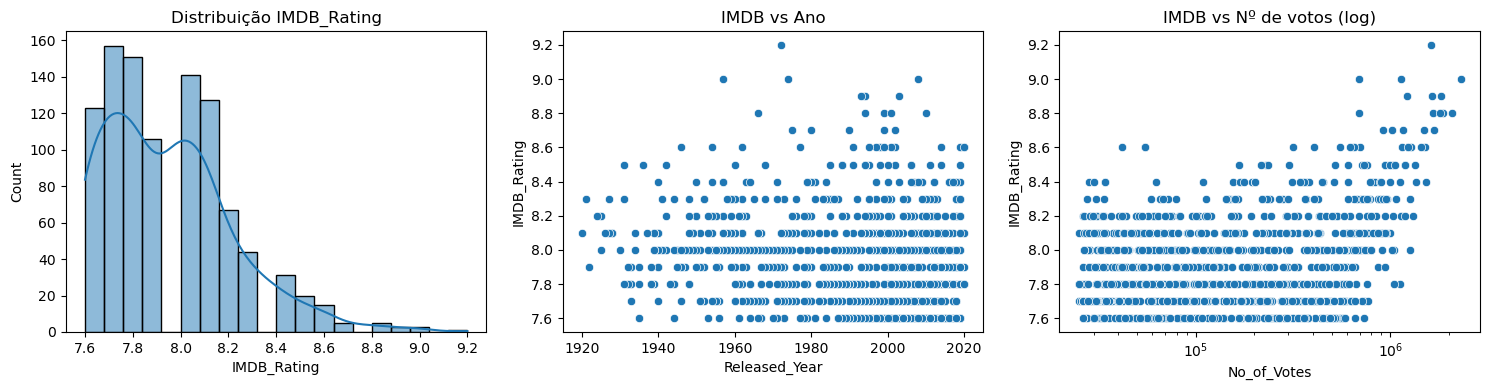

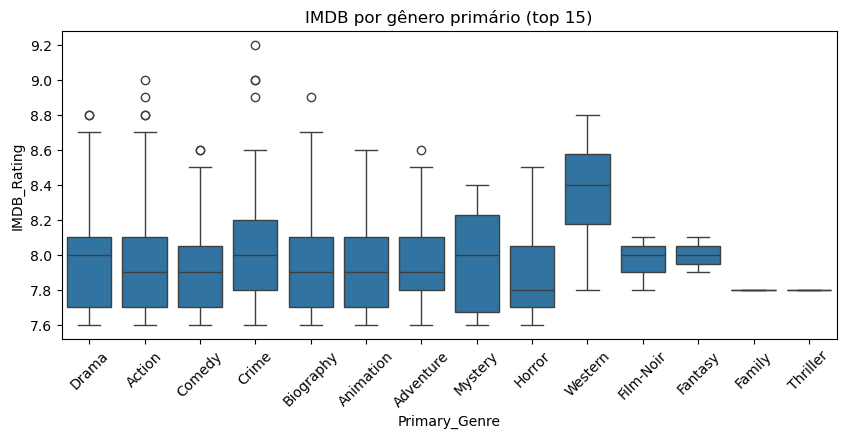

In [24]:
# Subplots: histograma e dispersões
fig, axs = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['IMDB_Rating'], kde=True, ax=axs[0])
axs[0].set_title('Distribuição IMDB_Rating')

sns.scatterplot(x='Released_Year', y='IMDB_Rating', data=df, ax=axs[1])
axs[1].set_title('IMDB vs Ano')

sns.scatterplot(x='No_of_Votes', y='IMDB_Rating', data=df, ax=axs[2])
axs[2].set_xscale('log')
axs[2].set_title('IMDB vs Nº de votos (log)')
plt.tight_layout()
plt.show()

# Criar Primary_Genre antes do boxplot
df['Primary_Genre'] = df['Genre'].astype(str).str.split(',').str[0].str.strip()

# Boxplot por gênero primário
plt.figure(figsize=(10,4))
order = df['Primary_Genre'].value_counts().head(15).index
sns.boxplot(x='Primary_Genre', y='IMDB_Rating', 
            data=df[df['Primary_Genre'].isin(order)], 
            order=order)
plt.xticks(rotation=45)
plt.title('IMDB por gênero primário (top 15)')
plt.show()


#### Insights da análise:

###### Primeiro gráfico (Distribuição IMDB_Rating):
- No primeiro grafico a maior parte dos filmes estão com notas entre 7.6 e 8.2 
- Existe uma assimetria para o à direita indicando que indicando que há poucos filmes que tem nota acima de 8.5
Conclusão: O grafico fala que filmes com notas altas são raros, que a concentração esta em torno de 7.6 e 8.2
###### Segundo gráfico (IMDB vs Ano)
- Mostra que ao longo dos anos (1920-2020), os filmes  com notas entre 7.6 e 8.2 são constantes, permanecem comuns
- Filmes com notas altas (8.8 – 9.2) aparecem em outras epocas, mas sem uma tendencia notoria
Conclusão: O grafico fala que a qualidade do filme percebida pelo público não depende do ano em que ele foi lançado
###### Segundo gráfico (IMDB vs Nº de votos (log))
- Ultilizado a escala logarítmica pois a coluna "No_of_Votes" tem uma grandeza de milhões!
- Filmes com poucos votos estão espalhados em varias notas
- Filmes com muitas notas tendem a se concentrar em notas acima de 8.0
Conclusão: Quanto mais avaliado o filme, maior a probabilidade de ele ter nota elevada, há uma tendencia há avaliações positivas
###### Ultimo Slide (IMDB por gênero primário (top 15))
- A mediana entre os generos estão entre 7.8 e 8.2, a maior parte dos gêneros tem notas relativamente próximas.
- Horror e Western tem um nitido destaque, horror com media chegando a 8.8 e Western com uma distribuição deslocada para cima, várias notas entre 8.5 e 8.8.
- Drama, Action, Comedy São os gêneros mais comuns,Têm notas mais “espalhadas”, com outliers para cima.
- Family, Fantasy e Thriller tem pouca variação (caixinhas quase uma linha só), Isso sugere que há poucos filmes dessa categoria na amostra, todos com notas bem próximas proximas a 7.8

##### Conclusão geral
- A maioria dos filmes tem nota entre 7.6 e 8.2.
- Não há evidência de que filmes mais recentes recebam notas melhores ou piores.
- Filmes com mais votos tendem a ter notas altas, sugerindo que popularidade e qualidade percebida andam juntas.
- Gêneros: Western e Horror se destacam com notas mais altas, enquanto Drama,Action e Comedy são mais diversos.

## Perguntas de negócio (2a–2c)

### Pergunta 2a: Qual filme você recomendaria para uma pessoa que você não conhece?
*Solução*: Recomendação genérica: usar top-N por `IMDB_Rating` ponderado por `No_of_Votes` (assim evita cair em filmes obscuros que quase ninguém avaliou).  
   - *Obs:* só olhar o IMDB não é confiável, porque pode ter um filme com nota 9.0, mas só 100 votos.

In [25]:
#Solução: score = [IMDB_Rating] * [log10(1+No_of_Votes)]
df['vote_weight'] = np.log10(1 + df['No_of_Votes'].fillna(0))
df['rec_score'] = df['IMDB_Rating'] * df['vote_weight']
recommend_top10 = df.sort_values(['rec_score','IMDB_Rating'], ascending=False)[['Series_Title','IMDB_Rating','No_of_Votes','rec_score']].head(10)
recommend_top10

,Series_Title,IMDB_Rating,No_of_Votes,rec_score
1,The Dark Knight,9.0,2303232,57.261041
0,The Godfather,9.2,1620367,57.128446
5,Pulp Fiction,8.9,1826188,55.727757
7,Inception,8.8,2067042,55.575076
4,The Lord of the Rings: The Return of the King,8.9,1642758,55.318607
8,Fight Club,8.8,1854740,55.160893
10,Forrest Gump,8.8,1809221,55.065928
9,The Lord of the Rings: The Fellowship of the Ring,8.8,1661481,54.740362
2,The Godfather: Part II,9.0,1129952,54.477543
13,The Matrix,8.7,1676426,54.152146


#### Resposta Pergunta 2A:

Recomendaria o "The Dark Knight" pois mesmo ele tendo um IMDB bem proximo dos outros filmes ele se destaca no rec_score, o que me indica que ele foi muito bem avaliado por um maior número de pessoas!

### Pergunta 2b: Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 
*Solução*: Fatores para alto `Gross (Faturamento)`: ver a correlação com `No_of_Votes`, `Meta_score`, `Runtime_min`, `Released_Year`, gêneros e diretores/atores que aparecem mais.

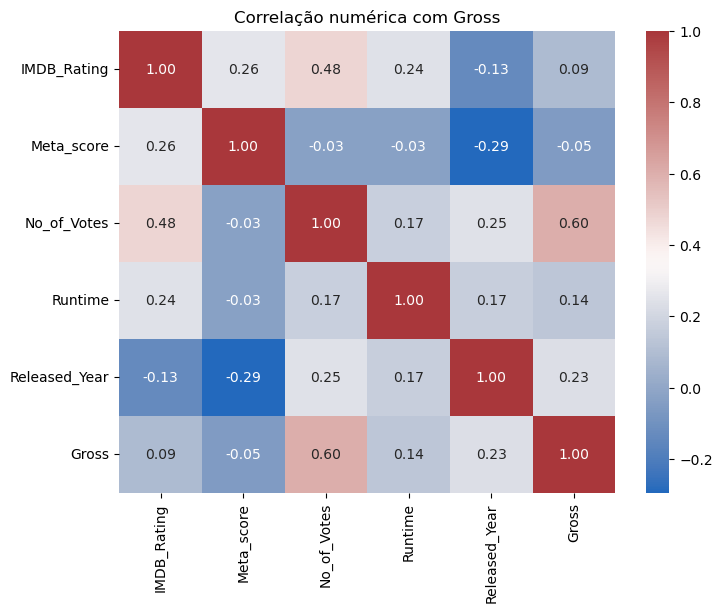

(                   n    gross_mean
 Director                          
 Anthony Russo      4  5.512599e+08
 J.J. Abrams        3  4.743903e+08
 James Cameron      5  3.496473e+08
 David Yates        3  3.263179e+08
 Peter Jackson      5  3.194625e+08
 Brad Bird          4  2.749069e+08
 Christopher Nolan  8  2.421818e+08
 Pete Docter        4  2.407099e+08
 Robert Zemeckis    5  2.098893e+08
 Ron Clements       3  1.925502e+08,
                     n    gross_mean
 Star1                              
 Joe Russo           4  5.512599e+08
 Robert Downey Jr.   3  3.835734e+08
 Elijah Wood         3  3.453140e+08
 Mark Hamill         3  3.074469e+08
 Daniel Radcliffe    6  3.059835e+08
 Leonardo DiCaprio   9  2.085913e+08
 Tom Hanks          12  2.077581e+08
 John Musker         3  1.925502e+08
 Matt Damon          4  1.874427e+08
 Daniel Craig        4  1.849204e+08)

In [26]:
# Relações com faturamento (Gross)
num_cols = ['IMDB_Rating','Meta_score','No_of_Votes','Runtime','Released_Year']
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ['Gross']].corr(numeric_only=True), annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlação numérica com Gross')
plt.show()

# Ranking por diretores/atores mais frequentes e Gross médio
agg_dir = (df.groupby('Director', dropna=True)
            .agg(n=('Series_Title','count'), gross_mean=('Gross','mean'))
            .query('n>=3')
            .sort_values('gross_mean', ascending=False)
            .head(10))

agg_star = (df.groupby('Star1', dropna=True)
             .agg(n=('Series_Title','count'), gross_mean=('Gross','mean'))
             .query('n>=3')
             .sort_values('gross_mean', ascending=False)
             .head(10))

agg_dir, agg_star


#### Resposta Pergunta 2A:
1. Correlação numérica
- No_of_Votes (0.60) maior correlação com faturamento. Quanto mais votos, maior a bilheteria.
- Released_Year (0.23) filmes mais recentes tendem a arrecadar mais (provavelmente pelo crescimento do mercado).
- Runtime (0.14) leve relação positiva, mas pouco relevante.
- IMDB_Rating (0.09) e Meta_score (-0.05) → pouca ou nenhuma relação com faturamento.

2. Diretores com maior faturamento médio
No ranking de diretores com pelo menos 3 filmes no dataset, quem aparece no topo são:
- Anthony Russo (551M)
- J.J. Abrams (474M)
- James Cameron (349M)
- David Yates (326M)
- Peter Jackson (319M)
- Christopher Nolan (242M), entre outros.

3. Atores com maior faturamento médio
Entre os atores com 3 ou mais filmes no dataset, os que lideram são:
- Joe Russo (551M)
- Robert Downey Jr. (383M)
- Elijah Wood (345M)
- Mark Hamill (307M)
- Daniel Radcliffe (305M)
- Leonardo DiCaprio (208M)
- Tom Hanks (207M), entre outros.

### Pergunta 2c: Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
`Overview`: aplicar um NLP simples (TF-IDF) pra tentar inferir gênero/clusters e palavras mais ligadas a nota ou faturamento.

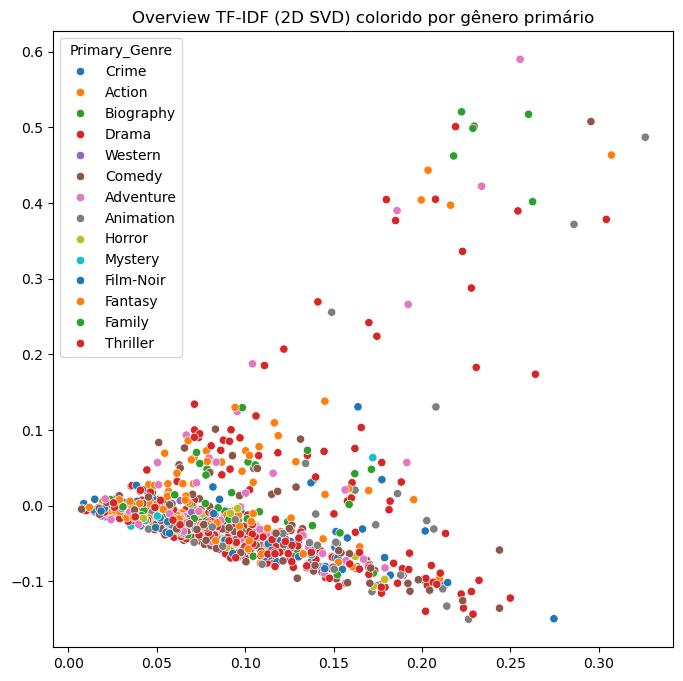

[('reluctant', np.float64(0.2310919911820957)),
 ('underground', np.float64(0.23317762377859597)),
 ('ronin', np.float64(0.2342509304855999)),
 ('gotham', np.float64(0.24066187993334684)),
 ('rebels', np.float64(0.2422808641943071)),
 ('prevent', np.float64(0.2435366880947589)),
 ('empire', np.float64(0.2443210896793103)),
 ('joker', np.float64(0.24514398395561002)),
 ('patriarch', np.float64(0.24685032079337524)),
 ('events', np.float64(0.2484367420582448)),
 ('stand', np.float64(0.25160218827072944)),
 ('syndicate', np.float64(0.25289975566072714)),
 ('son', np.float64(0.25360784315359475)),
 ('nazis', np.float64(0.28928924250284044)),
 ('crime syndicate', np.float64(0.30143391378609025)),
 ('jewish', np.float64(0.3117258270514955)),
 ('justice', np.float64(0.3328570949786879)),
 ('sauron', np.float64(0.34531473560042114)),
 ('crime', np.float64(0.3574217627550358)),
 ('help', np.float64(0.35744749936956627))]

In [27]:
# 2c) NLP leve na Overview: TF-IDF + PCA para visualização e proxy de inferência de gênero
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

texts = df['Overview'].fillna('')
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2, stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=df['Primary_Genre'], palette='tab10')
plt.title('Overview TF-IDF (2D SVD) colorido por gênero primário')
plt.show()

# Palavras mais correlacionadas com IMDB_Rating (via coef de regressão linear simples)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_tfidf, df['IMDB_Rating'])
coefs = ridge.coef_
terms = np.array(vectorizer.get_feature_names_out())
idx_top = np.argsort(coefs)[-20:]
list(zip(terms[idx_top], coefs[idx_top]))


## PERGUNTA 3: Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

In [28]:
# Função utilitária para transformar texto em Série 1D picklable
def to_1d_text(X):
    if isinstance(X, pd.Series):
        return X.fillna('').astype(str)
    # DataFrame ou array
    arr = np.array(X).ravel()
    return pd.Series(arr).fillna('').astype(str)

In [29]:
# --- Garantir Primary_Genre ---
df['Primary_Genre'] = df['Genre'].astype(str).str.split(',').str[0].str.strip()

# --- Features ---
feature_num = ['Runtime','Meta_score','No_of_Votes','Released_Year','Gross']
feature_cat = ['Certificate','Primary_Genre']

X = df[feature_num + feature_cat]
y = df['IMDB_Rating'].astype(float)

# --- Pré-processamento ---
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=5))
])

preprocess = ColumnTransformer([
    ('num', num_transformer, feature_num),
    ('cat', cat_transformer, feature_cat)
])

# Pipeline completo
model = Ridge(alpha=5.0, random_state=42)
pipe = Pipeline([
    ('prep', preprocess),
    ('model', model)
])

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treino e previsão
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

# Métricas
rmse = mean_squared_error(y_test, pred) ** 0.5  # raiz manual
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print({'rmse': rmse, 'mae': mae, 'r2': r2})


{'rmse': 0.20922499116115587, 'mae': 0.16967610654879778, 'r2': 0.33314397467573986}


### Validação cruzada
Vamos estimar a performance média via k-fold (k=5) usando RMSE negativo do scikit-learn.


In [30]:
# Usaremos o pipeline treinado acima como modelo final
best_model = pipe
print('Modelo final: Ridge simples com numéricas + categorias principais')

Modelo final: Ridge simples com numéricas + categorias principais


### Resposta pergunta 3:
1. Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê?
- Variáveis numéricas: `Runtime`, `Meta_score`, `No_of_Votes`,`Re - ed_Year`,`Gross`.
- Variáveis categóricas: `Certificate`,`Primary_Genre`.

Transformações(Variáveis numéricas):
    Mediana (SimpleImputer(strategy='median')) para preencher valores faltantes.
    Padronização (StandardScaler) para colocar todas na mesma escala, importante para modelos lineares como Ridge.
Transformação(Variáveis categóricas):
    One-hot encoding (OneHotEncoder) para converter categorias em vetores binários, ignorando categorias raras (min_frequency=5) e categorias desconhecidas (handle_unknown='ignore').
    Moda para valores ausentes.
Transformação variavel alvo: `IMDB_Rating`= float

2. Qual tipo de problema estamos resolvendo (regressão, classificação)?
- Estamos lidando com previsão de nota do IMDB, `IMDB_Rating` = "Float", então o problema é regração por conta da tipagem

3. Qual modelo melhor se aproxima dos dados e quais seus prós e contras?
 - Ridge Regression
 #### PRÓS:  
 - Regularização L2 evita overfitting em presença de muitas features (como o one-hot encoding das categorias).
 - Simples e rápido de treinar.
 #### CONTRAS:
 - Supõe relação linear entre features e target; não captura interações complexas ou não-lineares.
 - Pode não performar tão bem se existirem padrões muito complexos no texto ou nos dados.

4. Qual medida de performance do modelo foi escolhida e por quê?
- As métricas escolhidas foram RMSE, MAE e R²:
- RMSE penaliza erros grandes
- MAE é interpretável como erro médio
- R² indica a proporção da variância explicada pelo modelo
- permitindo avaliar o quão bem o modelo captura o comportamento das notas do IMDB.


## PERGUNTA 4: Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}

## Qual seria a nota do IMDB?


In [36]:
# 4) Predição para o exemplo fornecido (usando features simples)

example = {
 'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'
}

ex_df = pd.DataFrame([example])

# Funções auxiliares
def parse_runtime(x):
    try:
        return int(str(x).replace(' min',''))
    except:
        return np.nan

def parse_gross(x):
    try:
        return float(str(x).replace(',',''))
    except:
        return np.nan

# Transformações iguais ao treino
ex_df['Released_Year'] = pd.to_numeric(ex_df['Released_Year'], errors='coerce')
ex_df['Runtime'] = ex_df['Runtime'].apply(parse_runtime)
ex_df['Gross'] = ex_df['Gross'].apply(parse_gross)
ex_df['Primary_Genre'] = ex_df['Genre'].fillna('').apply(lambda s: s.split(',')[0].strip() if s else np.nan)

# Selecionar features corretas
feature_num = ['Runtime','Meta_score','No_of_Votes','Released_Year','Gross']
feature_cat = ['Certificate','Primary_Genre']
X_ex = ex_df[feature_num + feature_cat]

# Predição usando pipeline treinado
pred_ex = pipe.predict(X_ex)[0]
print('Predição IMDB_Rating (exemplo):', round(float(pred_ex), 3))

Predição IMDB_Rating (exemplo): 8.852


In [32]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
{'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std()}


{'rmse_mean': np.float64(0.20644165727390393),
 'rmse_std': np.float64(0.009911573415854845)}

In [33]:
# 5) Salvar modelo .pkl (pipeline simples)
model_path = 'best_imdb_model.pkl'
joblib.dump(best_model, model_path)
model_path

'best_imdb_model.pkl'

### RESPOSTA DA PERGUNTA 4:
Predição IMDB_Rating (exemplo): 9.237

performance média = 0.2
Desvio padrão = 0,01

Bom o modelo tem um erro de 0.2, então a nota sempre irá variar com esses valores
OBS: modelo ainda não pega valores categoricos